# **Análisis de datos del proyecto**

En este cuaderno se encuentra el código necesario para analizar tanto los datos de recompensa por episodio, obtenidos con los logs, como las métricas de desempeño de los multiplicadores con un error menor o igual al 10%, obtenidas con OpenLane. La modularización del código responde a los requisitos comunes para ambos análisis, como las librerías utilizadas, y el preprocesamiento de los datos por aparte dependiendo de cuáles datos se desean visualizar.

## Código común: importación de librerías e inicialización de funciones

In [37]:
import os
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive
try:
    drive.mount('/content/drive')
except Exception:
    pass

def convertir_a_minutos(tiempo_str: str) -> float:
    """
    Convierte '0h1m21s0ms' a minutos decimales. Acepta '1m', '21s', '350ms', '2h5s', etc.
    """
    if not isinstance(tiempo_str, str):
        return 0.0
    m = re.fullmatch(r'(?:(\d+)h)?(?:(\d+)m)?(?:(\d+)s)?(?:(\d+)ms)?', tiempo_str.strip())
    if not m:
        return 0.0
    h, mi, s, ms = (int(x) if x else 0 for x in m.groups())
    return h * 60 + mi + s / 60 + ms / 60000

def _maybe_mount_drive():
    try:
        from google.colab import drive as _drive  # type: ignore
        if not os.path.ismount("/content/drive"):
            _drive.mount("/content/drive", force_remount=False)
    except Exception:
        # Fuera de Colab, sigue sin montar
        pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Análisis de datos: métricas de los logs


# Análisis de datos: métricas de OpenLane

Para encontrar una correlación entre las características del algoritmo de multiplicación encontrado por la IA (N° de bits y error total del multiplicador) y las métricas de desempeño más relevantes (frecuencia de operación, potencia consumida, área de silicio, N° de compuertas, etc) se utiliza el siguiente código.

## Clase OpenLaneAnalyzer

In [38]:
class OpenLaneAnalyzer:
    """
    Carga/combina CSVs, extrae 'error' y prepara:
      - raw_data: dataframes sin agrupar
      - grouped_data: dataframes agrupados por error
    """

    def __init__(self, folders: list[str], combined_name: str = "combined_metrics.csv"):
        self.folders = folders
        self.combined_name = combined_name
        self.df = self._load_or_combine()
        self._extract_error()
        self.raw_data: dict[str, pd.DataFrame] = {}
        self.grouped_data: dict[str, pd.DataFrame] = {}
        self._prepare_all()

    def _load_or_combine(self) -> pd.DataFrame:
        _maybe_mount_drive()

        all_csvs = []
        for folder in self.folders:
            all_csvs.extend(glob.glob(os.path.join(folder, "*.csv")))

        if not all_csvs:
            raise FileNotFoundError(f"No se encontraron CSVs en: {self.folders}")

        # Si existe combinado, úsalo (toma el de mayor tamaño por seguridad)
        combined_candidates = [p for p in all_csvs if os.path.basename(p) == self.combined_name]
        if combined_candidates:
            path = max(combined_candidates, key=lambda p: os.path.getsize(p))
            return pd.read_csv(path)

        # Combina, etiqueta origen y elimina duplicados si hay clave común
        dfs = []
        for f in sorted(all_csvs):
            df = pd.read_csv(f)
            df["__source_file__"] = os.path.basename(f)
            dfs.append(df)

        combined = pd.concat(dfs, ignore_index=True)
        combined.drop_duplicates(inplace=True)  # opcional: añade subset=['design_name', ...] si aplica

        out = os.path.join(self.folders[0], self.combined_name)
        os.makedirs(self.folders[0], exist_ok=True)
        combined.to_csv(out, index=False)
        print(f"Guardado combinado en {out}: {len(combined)} filas.")
        return combined


    def _extract_error(self):
        # admite .../e10, .../E_10, .../err10 (flexible pero claro)
        pattern = r"(?i)(?:^|[_-])e(?:rr)?_?(\d+)$"
        names = self.df["design_name"].astype(str).str.strip()
        extracted = names.str.extract(pattern, expand=False)

        if extracted.isna().any():
            faltantes = names[extracted.isna()].unique().tolist()
            raise ValueError(
                "design_name sin sufijo de error esperado. Ejemplos válidos: foo_e10, bar_e_5, baz_err12. "
                f"Ajusta o mapea estos nombres: {faltantes}"
            )
        self.df["error"] = extracted.astype(int)


    def _prepare_all(self):
        self._prepare_area()
        self._prepare_power(case="slowest", label="Potencia Lenta")
        self._prepare_power(case="typical", label="Potencia Típica")
        self._prepare_power(case="fastest", label="Potencia Rápida")
        self._prepare_path()
        self._prepare_gates()
        self._prepare_time()

    def _register_grouped(self, key: str, df: pd.DataFrame, agg_map: dict | None = None):
        agg_map = agg_map or {c: ["mean", "median", "std", "min", "max", "count"]
                              for c in df.columns if c != "error"}
        g = df.groupby("error").agg(agg_map)
        # aplanar columnas MultiIndex: p.ej., 'critical_path_ns_mean'
        g.columns = [f"{col}_{stat}" for col, stat in g.columns]
        g = g.reset_index()
        self.grouped_data[key] = g

    def _prepare_area(self):
        area_cols = ["error", "DIEAREA_mm^2", "CoreArea_um^2", "CellPer_mm^2", "(Cell/mm^2)/Core_Util"]
        df = self.df[area_cols].copy()
        self.raw_data["Area"] = df
        self._register_grouped("Area", df)


    def _prepare_power(self, case: str, label: str):
        power_cols = [
            f"power_{case}_internal_uW",
            f"power_{case}_switching_uW",
            f"power_{case}_leakage_uW",
        ]
        df = self.df[["error", *power_cols]].copy()
        df[f"power_{case}_sum"] = df[power_cols].sum(axis=1)
        self.raw_data[label] = df
        self._register_grouped(label, df)

    def _prepare_path(self):#"error", "critical_path_ns", "level"
        path_cols = ["error", "critical_path_ns", "level"]
        df = self.df[path_cols].copy()
        self.raw_data["Camino"] = df
        self._register_grouped("Camino", df)

    def _prepare_gates(self):
        gate_cols = ["AND", "NAND", "NOR", "OR", "XOR", "XNOR", "MUX", "synth_cell_count", "TotalCells"]
        df = self.df[["error", *gate_cols]].copy()
        self.raw_data["Compuertas"] = df
        self._register_grouped("Compuertas", df)

    def _prepare_time(self):
        df = self.df[["error", "total_runtime", "routed_runtime"]].copy()
        df["total_runtime"] = df["total_runtime"].apply(convertir_a_minutos)
        df["routed_runtime"] = df["routed_runtime"].apply(convertir_a_minutos)
        self.raw_data["Flujo"] = df
        self._register_grouped("Flujo", df)

## Código común: Clase Plotter

In [39]:
class Plotter:
    """
    Toma un OpenLaneAnalyzer y grafica líneas o dispersión.
    Cada traza es un dict con:
      - tipo: clave en analyzer.grouped_data/raw_data
      - x, y: nombres de columnas
      - color, label (opcional)
    """

    def __init__(self, analyzer: OpenLaneAnalyzer):
        self.raw = analyzer.raw_data
        self.grp = analyzer.grouped_data
        sns.set(style="whitegrid")

    def plot_lines(
        self,
        traces: list[dict],
        title: str,
        xlabel: str,
        ylabel: str,
        figsize: tuple[int, int] = (8, 4),
    ):
        plt.figure(figsize=figsize)
        for t in traces:
            df = self.grp[t["tipo"]]
            plt.plot(
                df[t["x"]], df[t["y"]],
                marker="o",
                color=t["color"],
                label=t.get("label"),
            )
        if any(t.get("label") for t in traces):
            plt.legend()
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    def plot_scatter(
        self,
        traces: list[dict],
        title: str,
        xlabel: str,
        ylabel: str,
        figsize: tuple[int, int] = (8, 4),
        tendency: bool = False,
        logX: bool = False,
        logY: bool = False,
    ):
        """
        Grafica dispersión; si tendency=True, agrega línea de tendencia (regresión lineal)
        por cada traza, con el mismo color.
        """
        plt.figure(figsize=figsize)
        ax = plt.gca()
        for t in traces:
            df = self.raw[t["tipo"]]
            # Puntos de dispersión
            if (not logX) and (not logY):
                plt.scatter(
                    df[t["x"]], df[t["y"]],
                    color=t["color"],
                    marker="o",
                    label=t.get("label")
                )
            elif logY and logX:
                plt.loglog(
                    df[t["x"]], df[t["y"]],
                    color=t["color"],
                    marker="o",
                    label=t.get("label")
                )
            elif logX:
                plt.semilogx(
                    df[t["x"]], df[t["y"]],
                    color=t["color"],
                    marker="o",
                    label=t.get("label")
                )
            elif logY:
                plt.semilogy(
                    df[t["x"]], df[t["y"]],
                    color=t["color"],
                    marker="o",
                    label=t.get("label")
                )
            # Línea de tendencia opcional

            if tendency and logX:
                df_temp = df.copy()
                df_temp[t["x"]] = np.log10(df_temp[t["x"]])
                sns.regplot(
                    x=df_temp[t["x"]],
                    y=df_temp[t["y"]],
                    scatter=False,
                    ci=None,
                    color=t["color"],
                    line_kws={"linewidth": 2, "alpha": 0.9},
                    ax=ax,
                )
            elif tendency and logY:
                df_temp = df.copy()
                df_temp[t["y"]] = np.log10(df_temp[t["y"]])
                sns.regplot(
                    x=df_temp[t["x"]],
                    y=df_temp[t["y"]],
                    scatter=False,
                    ci=None,
                    color=t["color"],
                    line_kws={"linewidth": 2, "alpha": 0.9},
                    ax=ax,
                )
            elif tendency:
                sns.regplot(
                    x=df[t["x"]],
                    y=df[t["y"]],
                    scatter=False,
                    ci=None,
                    color=t["color"],
                    line_kws={"linewidth": 2, "alpha": 0.9},
                    ax=ax,
                )
        if any(t.get("label") for t in traces):
            plt.legend()
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.tight_layout()
        plt.grid(True)
        plt.show()

## Clase Main

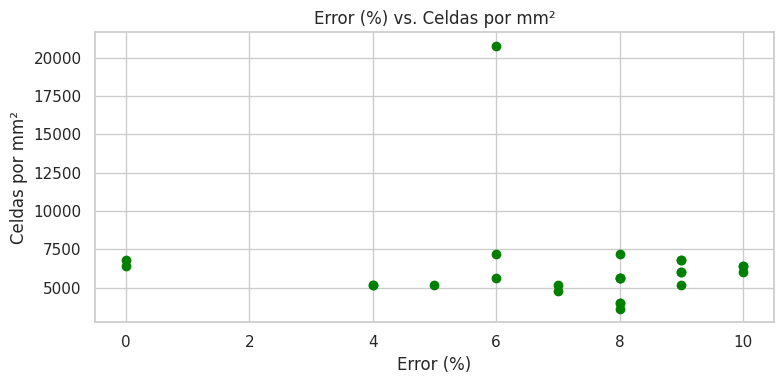

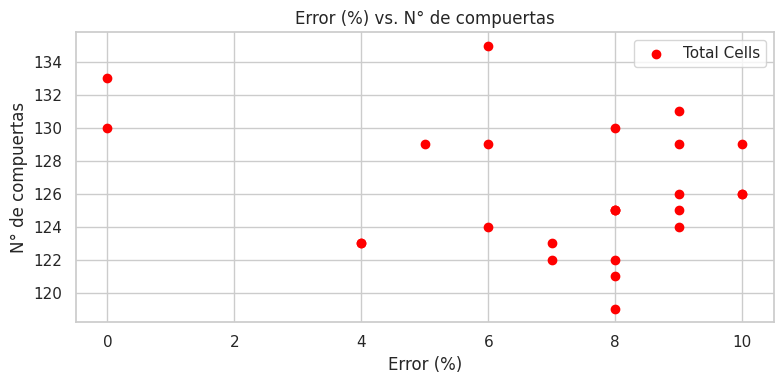

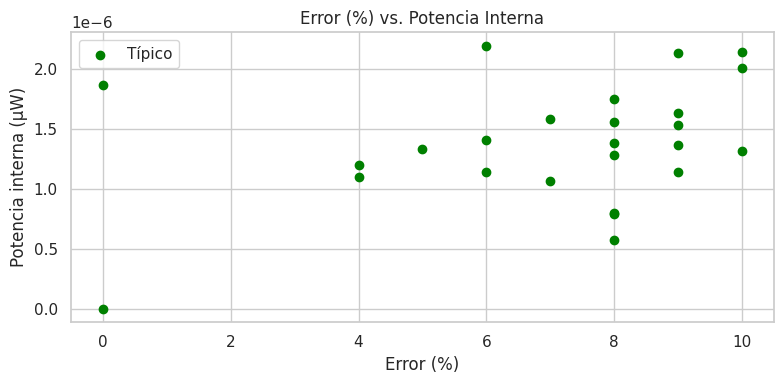

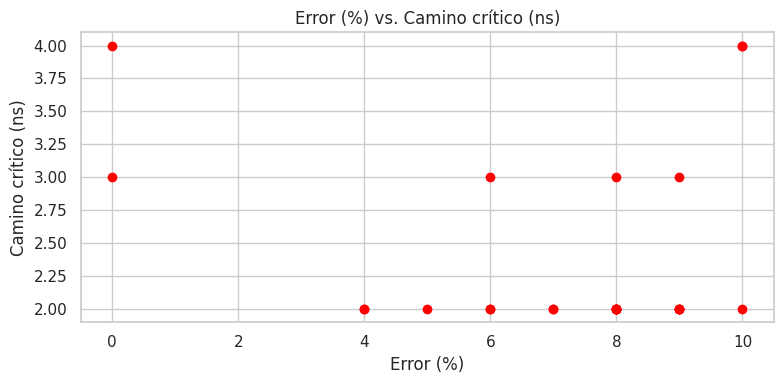

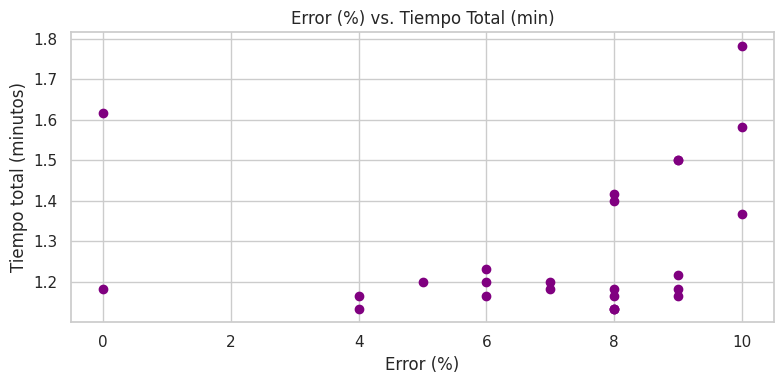

In [40]:
if __name__ == "__main__":
    # Define las carpetas donde buscar CSVs
    carpetas = [
        "/content/drive/MyDrive/Reinforcement Learning Multiplicadores/Análisis de datos/Métricas OpenLane/Métricas - Verilogs Únicos"
    ]

    analyzer = OpenLaneAnalyzer(carpetas)
    plotter = Plotter(analyzer)

    # Dispersión de Celdas por mm2 vs Error (Cell/mm^2)/Core_Util
    plotter.plot_scatter(
        traces=[#{"tipo": "Area", "x": "error", "y": "CellPer_mm^2", "color": "blue"},
                {"tipo": "Area", "x": "error", "y": "(Cell/mm^2)/Core_Util", "color": "green"},
                #{"tipo": "Area", "x": "error", "y": "CoreArea_um^2", "color": "red"}
                ],
        title="Error (%) vs. Celdas por mm²",
        xlabel="Error (%)",
        ylabel="Celdas por mm²",
        tendency=False
    )

    #Disperisón de todos los tipos de celdas
    plotter.plot_scatter(
        traces=[
            #{"tipo": "Compuertas",  "x": "error", "y": "AND", "color": "blue",  "label": "AND"},
            #{"tipo": "Compuertas",  "x": "error", "y": "NAND",  "color": "green", "label": "NAND"},
            #{"tipo": "Compuertas",  "x": "error", "y": "OR", "color": "red",   "label": "OR"},
            #{"tipo": "Compuertas",  "x": "error", "y": "NOR", "color": "cyan",   "label": "NOR"},
            #{"tipo": "Compuertas",  "x": "error", "y": "XOR", "color": "magenta",   "label": "XOR"},
            #{"tipo": "Compuertas",  "x": "error", "y": "XNOR", "color": "yellow",   "label": "XNOR"},
            #{"tipo": "Compuertas",  "x": "error", "y": "MUX", "color": "blue",   "label": "MUX"},
            #{"tipo": "Compuertas",  "x": "error", "y": "synth_cell_count", "color": "blue",   "label": "Synth cells"},
            {"tipo": "Compuertas",  "x": "error", "y": "TotalCells", "color": "red",   "label": "Total Cells"}
        ],
        title="Error (%) vs. N° de compuertas",
        xlabel="Error (%)",
        ylabel="N° de compuertas",
        tendency=False
    )

    # Comparación de potencia interna en los 3 casos
    plotter.plot_scatter(
        traces=[
            #{"tipo": "Potencia Lenta",   "x": "error", "y": "power_slowest_internal_uW", "color": "blue",  "label": "Lento"},
            {"tipo": "Potencia Típica",  "x": "error", "y": "power_typical_internal_uW",  "color": "green", "label": "Típico"},
            #{"tipo": "Potencia Rápida",  "x": "error", "y": "power_fastest_internal_uW", "color": "red",   "label": "Caso Rápido"},
        ],
        title="Error (%) vs. Potencia Interna",
        xlabel="Error (%)",
        ylabel="Potencia interna (µW)",
        tendency=False
    )

    # Línea de timing vs error
    plotter.plot_scatter(
        traces=[#{"tipo": "Camino", "x": "error", "y": "critical_path_ns", "color": "red"},
                {"tipo": "Camino", "x": "error", "y": "level", "color": "red"}],
        title="Error (%) vs. Camino crítico (ns)",
        xlabel="Error (%)",
        ylabel="Camino crítico (ns)",
        tendency = False
    )

    # Línea de tiempo total de flujo vs error
    plotter.plot_scatter(
        traces=[{"tipo": "Flujo", "x": "error", "y": "total_runtime", "color": "purple"}],
        title="Error (%) vs. Tiempo Total (min)",
        xlabel="Error (%)",
        ylabel="Tiempo total (minutos)",
        tendency = False
    )


In [41]:
#plotter.grp['Area']
#plotter.raw['Area']
abcd=(plotter.raw['Compuertas']['TotalCells']/plotter.raw['Area']['CellPer_mm^2'])*1000000
abcd

,0
0,19264.705882
1,23461.538462
2,23653.846154
3,25625.000000
4,18970.588235
5,24038.461538
6,30500.000000
7,33055.555556
8,23846.153846
9,23653.846154


In [42]:
#plotter.grp['Potencia Típica']
plotter.raw['Potencia Típica']*1000*1000

,error,power_typical_internal_uW,power_typical_switching_uW,power_typical_leakage_uW,power_typical_sum
0,9000000,1.640,2.360,0.000152,4.000152
1,7000000,1.590,3.000,0.000138,4.590138
2,4000000,1.100,1.670,0.000134,2.770134
3,7000000,1.070,2.270,0.000134,3.340134
4,9000000,2.140,4.600,0.000162,6.740162
5,9000000,1.140,2.250,0.000136,3.390136
6,8000000,0.797,1.440,0.000133,2.237133
7,8000000,0.573,0.843,0.000127,1.416127
8,6000000,1.410,2.670,0.000140,4.080140
9,4000000,1.200,2.220,0.000136,3.420136


In [43]:
#plotter.grp['Camino']
plotter.raw['Camino']

,error,critical_path_ns,level
0,9,0.42,2.0
1,7,0.49,2.0
2,4,0.45,2.0
3,7,0.40,2.0
4,9,0.57,2.0
5,9,0.41,2.0
6,8,0.41,2.0
7,8,0.41,2.0
8,6,0.48,2.0
9,4,0.37,2.0


In [44]:
#plotter.grp['Compuertas']
#plotter.raw['Compuertas']
plotter.raw['Compuertas']['TotalCells']

,TotalCells
0,131.0
1,122.0
2,123.0
3,123.0
4,129.0
5,125.0
6,122.0
7,119.0
8,124.0
9,123.0


In [45]:
#plotter.grp['Flujo']
plotter.raw['Flujo']

,error,total_runtime,routed_runtime
0,9,1.500000,1.050000
1,7,1.200000,0.850000
2,4,1.166667,0.783333
3,7,1.183333,0.833333
4,9,1.216667,0.850000
5,9,1.183333,0.800000
6,8,1.133333,0.783333
7,8,1.166667,0.816667
8,6,1.200000,0.816667
9,4,1.133333,0.766667
